In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class CrossAttention(nn.Module):
    def __init__(
        self,
        d_model: int = 512,
        num_heads: int = 8,
        dropout: float = 0.1
    ):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # dimension per head

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1))
        attn_scores /= math.sqrt(self.d_k)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float("-inf"))
        
        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        output = torch.matmul(attn_probs, V)
        return output, attn_probs
    
    def split_heads(self, hidden_states):
        batch_size, seq_len, d_model = hidden_states.size()
        # [Batch, SeqLen, Dim] -> [Batch, SeqLen, NumHeads, Dim]
        hidden_states = hidden_states.view(batch_size, seq_len, self.num_heads, self.d_k)
        # [Batch, SeqLen, NumHeads, Dim] -> [Batch, NumHeads, SeqLen, Dim]
        hidden_states = hidden_states.transpose(1, 2)
        return hidden_states
    
    def combine_heads(self, hidden_states):
        batch_size, num_heads, seq_len, d_k = hidden_states.size()
        # [Batch, NumHeads, SeqLen, Dim] -> [Batch, SeqLen, NumHeads, Dim]
        hidden_states = hidden_states.transpose(1, 2).contiguous()
        # [Batch, SeqLen, NumHeads, Dim] -> [Batch, SeqLen, Dim]
        hidden_states = hidden_states.view(batch_size, seq_len, self.d_model)
        return hidden_states
    
    def forward(self, seq1, seq2, mask=None):
        """
        seq1: Query sequence
        seq2: Key/Value sequence
        """
        Q = self.split_heads(self.q_proj(seq1))

        K = self.split_heads(self.k_proj(seq2))
        V = self.split_heads(self.v_proj(seq2))

        att_output, attn_probs = self.scaled_dot_product(Q, K, V, mask)

        output = self.combine_heads(att_output)
        output = self.o_proj(output)

        return output, attn_probs
    

In [3]:
def process_cross_attention():
    english = "the cat sat on the sofa"
    turkish = "kedi koltuğa oturdu"

    english = english.split()
    turkish = turkish.split()

    en_vocab = {w:i for i, w in enumerate(set(english))}
    tr_vocab = {w:i for i, w in enumerate(set(turkish))}

    en_indices = torch.tensor([[en_vocab[word] for word in english]])
    tr_indices = torch.tensor([[tr_vocab[word] for word in turkish]])

    d_model = 512
    en_embedding = nn.Embedding(len(en_vocab), d_model)
    tr_embedding = nn.Embedding(len(tr_vocab), d_model)

    en_embeds = en_embedding(en_indices) # Query
    tr_embeds = tr_embedding(tr_indices) # Key/Value

    cross_attention = CrossAttention(d_model, 8)
    output, attention = cross_attention(en_embeds, tr_embeds)
    return output, attention, english, turkish

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cross_attention(attention, lang1_tokens, lang2_tokens):
    """
    Lang1: Query
    Lang2: Key/Value
    """

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle("Cross Attention Patterns Across Heads", fontsize=16)

    attention_maps = attention[0] # First Batch
    for head_index, ax in enumerate(axes.flat):
        attn_map = attention_maps[head_index].detach().numpy().T

        sns.heatmap(
            attn_map,
            ax=ax,
            cmap="viridis",
            xticklabels=lang1_tokens,
            yticklabels=lang2_tokens,
            cbar=True,
            square=True
        )
        ax.set_title(f"Head {head_index+1}")
        ax.set_xlabel(f"Lang1 (Query)")
        ax.set_ylabel(f"Lang2 (Key/Value)")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.setp(ax.get_yticklabels(), rotation=0)
        ax.grid(True, which="minor", color="w", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [5]:
output, attention, english, turkish = process_cross_attention()

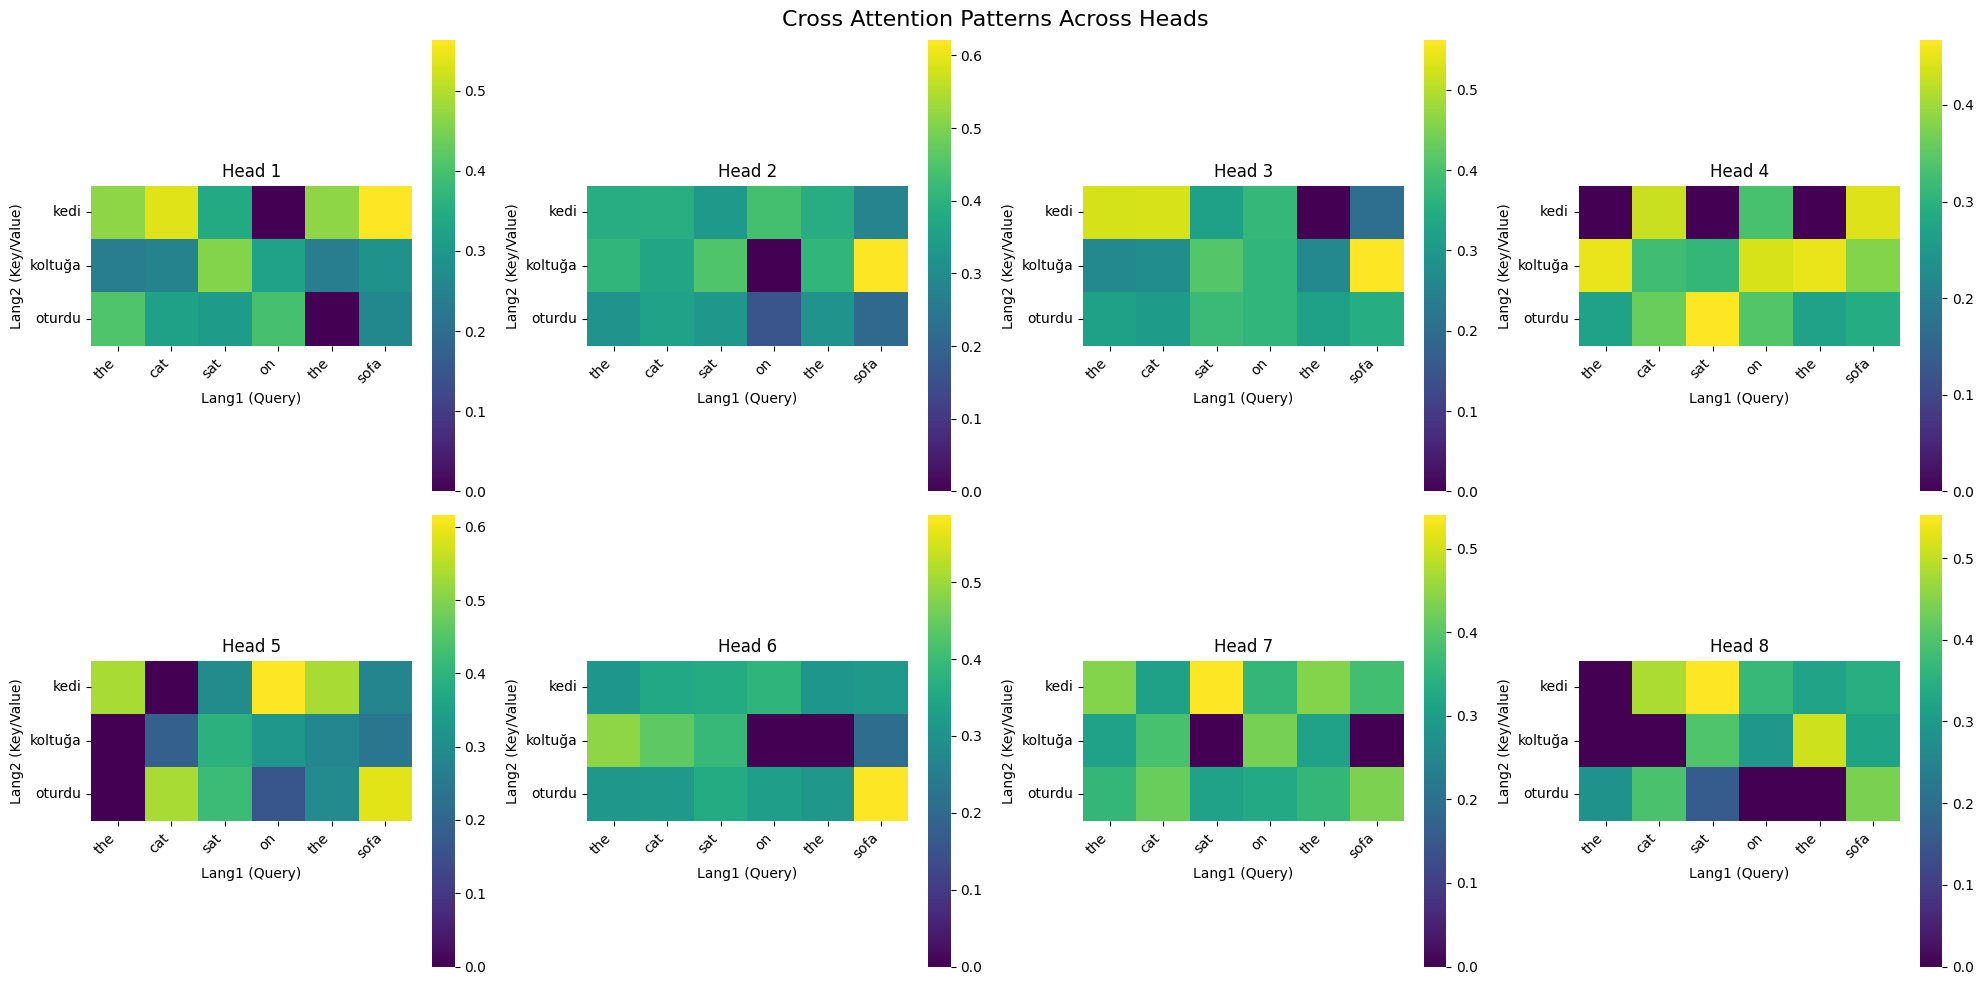

In [6]:
plot_cross_attention(attention, english, turkish)